# Credit Card Detection

Neste projeto iremos realizar detecção de fraudes em cartões de crédito. Os dados podem ser obtidos no dataset do kaggle: [Credit Card Fraud](https://www.kaggle.com/mlg-ulb/creditcardfraud)

# Importando dados e bibliotecas

## Dados do Kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import shutil

original = '/content/drive/MyDrive/kaggle.json'
target = '/content/kaggle.json'

shutil.copyfile(original, target)

'/content/kaggle.json'

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud

 97% 64.0M/66.0M [00:01<00:00, 33.2MB/s]
100% 66.0M/66.0M [00:01<00:00, 39.4MB/s]


In [6]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


## Importando principais bibliotecas e os dados

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

In [8]:
# Importando dados
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# Variáveis
feature_names = list(dataset.columns)
n_features = len(feature_names)

# Nomes das variáveis
features_string = ""
for i in range(n_features):
  if (i+1)%5>0:
    features_string += feature_names[i] + '\t'
  else:
    features_string += feature_names[i] + '\n'
print(features_string)

Time	V1	V2	V3	V4
V5	V6	V7	V8	V9
V10	V11	V12	V13	V14
V15	V16	V17	V18	V19
V20	V21	V22	V23	V24
V25	V26	V27	V28	Amount
Class	


# Verificando distribuição das variáveis

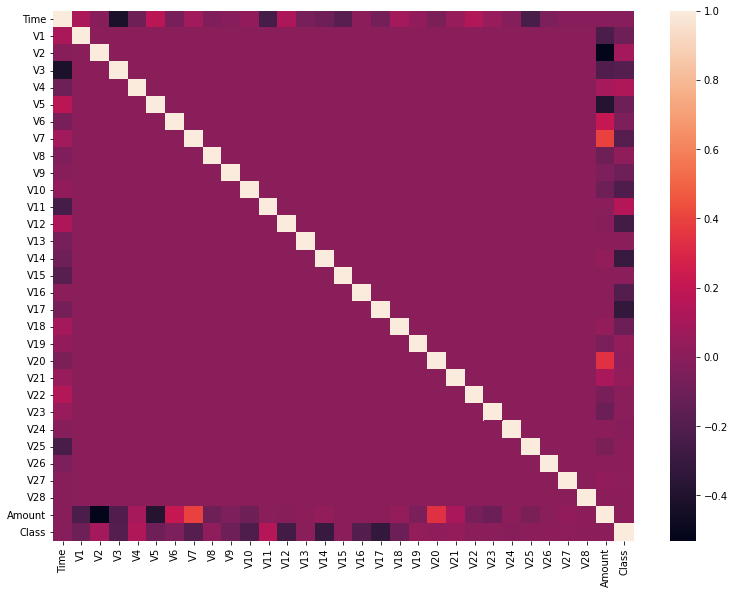

In [166]:
fig = plt.figure(figsize=(6.5*2,6.5*1.5))
sns.heatmap(dataset.corr())
plt.show()

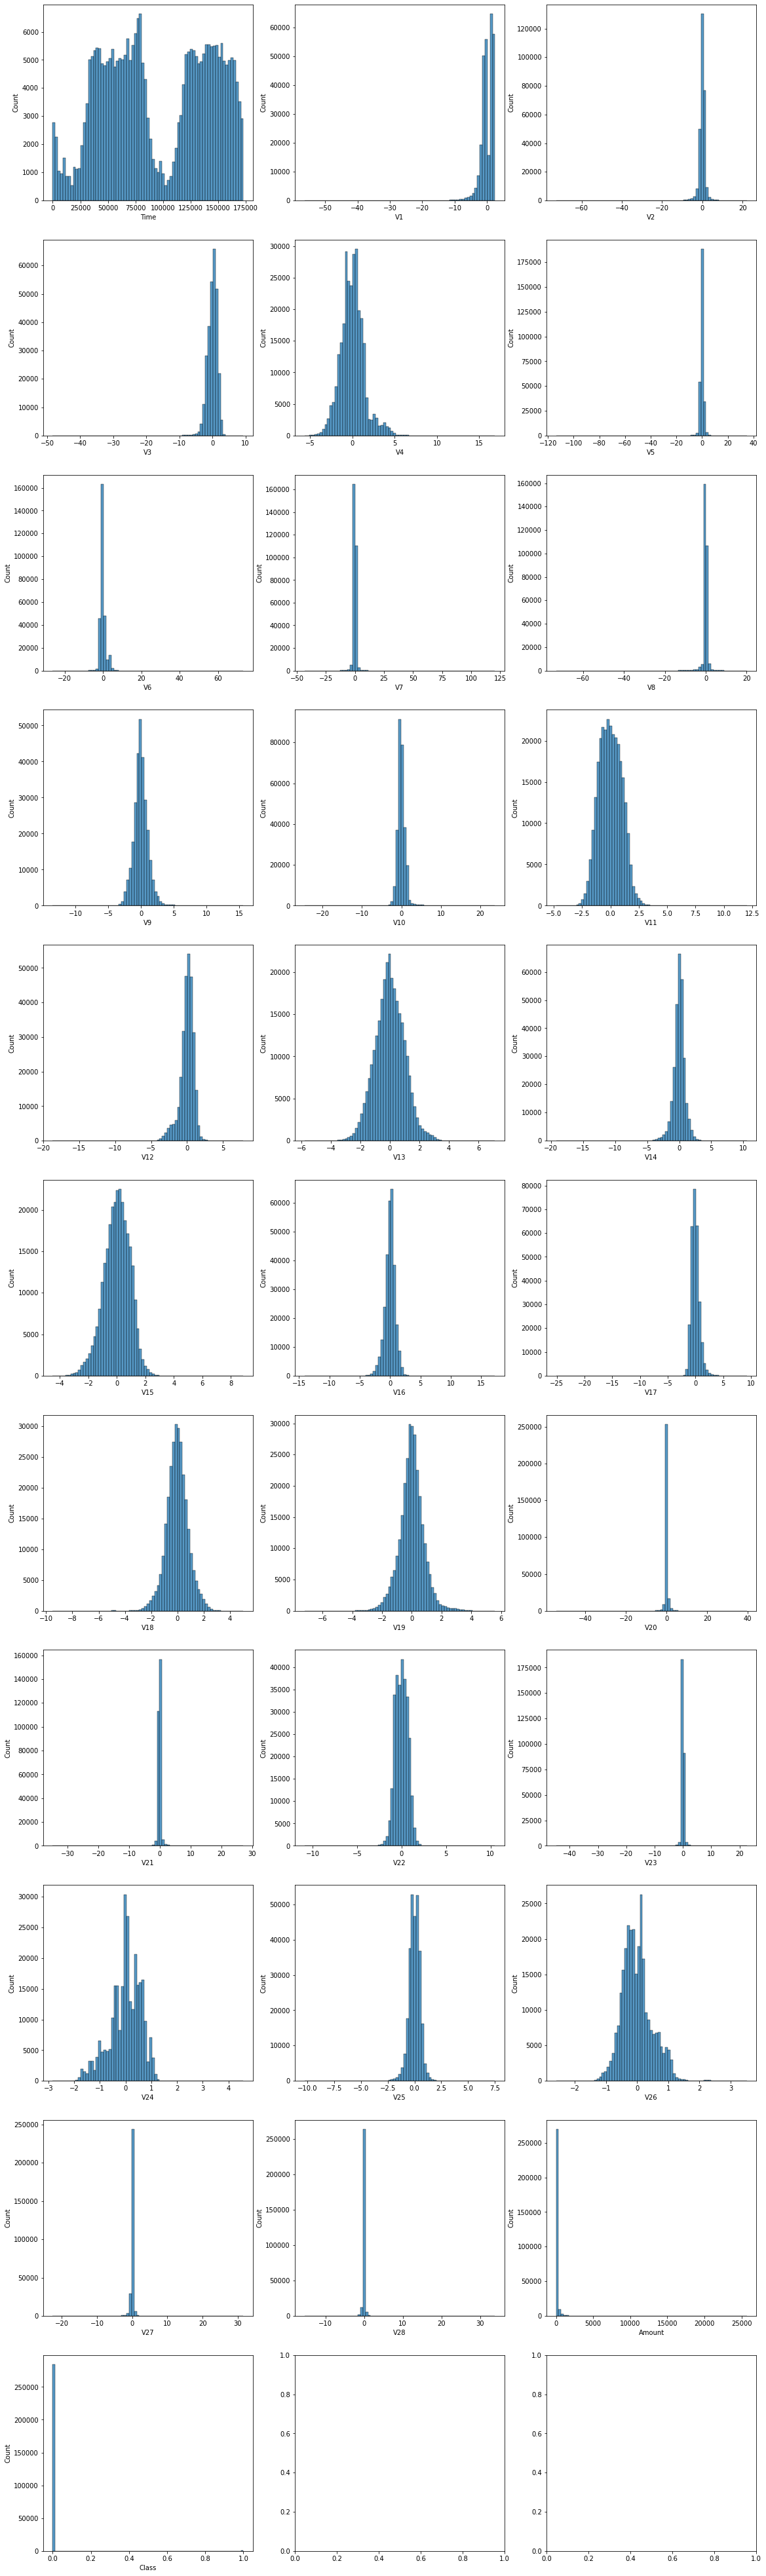

In [10]:
# Número de colunas e linhas para plotagem em grade
ncols = 3
nrows = (n_features//ncols) + 1 if n_features%ncols>0 else (n_features//ncols)


# Plotando histograma
fig,axes = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(6.5*ncols,6.5*nrows)

for i in range(n_features):
    col = i%ncols
    row = i//ncols 
    ax = axes[row,col]
    sns.histplot(data=dataset,x=feature_names[i],ax=ax,bins=75)
plt.show()
fig.savefig('dataset_histogram.pdf',dpi=300)

Vemos um forte desbalanceamento entre as classes. Para resolver esse problema iremos realizar um rebalanceamento.

Além disso, o banco de dados possui entre 250.000 e 300.000. Nesse caso, o modelo KNN provavelmente não será indicado. Outros modelos devem ter seu tamanho reduzido para facilitar no treinamento ou modelos que não utilizem todo o conjunto de dados simultaneamente.

## Balanceando os dados e amostragem estratificada

In [137]:
from sklearn.utils import resample

# Armazenando em numpy array's os dados
X = dataset.values[:,:-1]
y = dataset.values[:,-1:]



# Número de exemplos
n_examples = len(y)


# Separando os dados de não-fraude e os de fraude
# nf significa não-fraude
X_nf = X[y.reshape(-1) == 0,:]
y_nf = y[y.ravel() == 0]
n_examples_nf = len(y_nf)

# Embaralhando os dados
np.random.seed(43)
index_shuffling_nf = list(range(n_examples_nf))
np.random.shuffle(index_shuffling_nf)
np.random.seed(None)

X_nf,y_nf = X_nf[index_shuffling_nf,:],y_nf[index_shuffling_nf,:]


# Definindo os tamanhos dos dados de treino, teste e validação para não-fraude
# A divisão ficará 60%-20%-20%
train_size_nf = int(n_examples_nf*0.6)
val_size_nf = int(n_examples_nf*0.2)
test_size_nf = n_examples_nf - train_size_nf - val_size_nf


# Separando em dados de treino-teste-validação
X_nf_train,y_nf_train = X_nf[:train_size_nf],y_nf[:train_size_nf]
X_nf_val,y_nf_val = X_nf[train_size_nf:train_size_nf+val_size_nf],y_nf[train_size_nf:train_size_nf+val_size_nf]
X_nf_test,y_nf_test = X_nf[train_size_nf+val_size_nf:],y_nf[train_size_nf+val_size_nf:]




# Separando os dados de não-fraude e os de fraude
# f significa fraude
X_f = X[y.reshape(-1) == 1,:]
y_f = y[y.ravel() == 1]
n_examples_f = len(y_f)


# Embaralhando os dados
np.random.seed(42)
index_shuffling_f = list(range(n_examples_f))
np.random.shuffle(index_shuffling_f)
np.random.seed(None)

X_f,y_f = X_f[index_shuffling_f,:],y_f[index_shuffling_f,:]


# Definindo os tamanhos dos dados de treino, teste e validação para fraude
# A divisão ficará 60%-20%-20%
train_size_f = int(n_examples_f*0.6)
val_size_f = int(n_examples_f*0.2)
test_size_f = n_examples_f - train_size_f - val_size_f


# Separando em dados de treino-teste-validação
X_f_train,y_f_train = X_f[:train_size_f],y_f[:train_size_f]
X_f_val,y_f_val = X_f[train_size_f:train_size_f+val_size_f],y_f[train_size_f:train_size_f+val_size_f]
X_f_test,y_f_test = X_f[train_size_f+val_size_f:],y_f[train_size_f+val_size_f:]


# Rebalanceando os dados de treino e validação


X_f_train = resample(X_f_train,
                    replace=True,
                    n_samples=train_size_nf,
                    random_state=101)


y_f_train = resample(y_f_train,
                    replace=True,
                    n_samples=train_size_nf,
                    random_state=101)



X_f_val = resample(X_f_val,
                    replace=True,
                    n_samples=val_size_nf,
                    random_state=101)

y_f_val = resample(y_f_val,
                    replace=True,
                    n_samples=val_size_nf,
                    random_state=101)


# Concatenando os dados rebalanceados

X_train = np.concatenate((X_f_train,X_nf_train),axis=0)
y_train = np.concatenate((y_f_train,y_nf_train),axis=0)


X_val = np.concatenate((X_f_val,X_nf_val),axis=0)
y_val = np.concatenate((y_f_val,y_nf_val),axis=0)


X_test = np.concatenate((X_nf_test,X_f_test),axis=0)
y_test = np.concatenate((y_nf_test,y_f_test),axis=0)


# Definindo os tamanhos de treino, teste e validação novamente
train_size = len(y_train)
val_size = len(y_val)
test_size = len(y_test)
n_examples = train_size + val_size + test_size 

# Embaralhando novamente os dados de treino e validação
np.random.seed(101)
index_shuffling_train = list(range(train_size))
np.random.shuffle(index_shuffling_train)
np.random.seed(None)

X_train,y_train = X_train[index_shuffling_train],y_train[index_shuffling_train]


np.random.seed(101)
index_shuffling_val = list(range(val_size))
np.random.shuffle(index_shuffling_val)
np.random.seed(None)

X_val,y_val = X_val[index_shuffling_val],y_val[index_shuffling_val]


# Testando K-Means

O objetivo do K-Means dividir os dados em clusters e realizar associar probabilidades às distâncias de cada ponto aos centros dos clusters.

Além disso, o classificador deve possuir o recall maior possível, ou seja, o maior número possível de previsões de fraude, quando o dado corresponde à uma fraude.

In [138]:
from sklearn.preprocessing import MinMaxScaler

# Mudança de escala para facilitar o treinamento e tornar os dados mais estáveis
# No caso do KNN também ajuda na previsão de classes, visto variáveis diferentes provavelmente tem escalas diferentes
sc_X = MinMaxScaler()

X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.fit_transform(X_val)
X_test_sc = sc_X.transform(X_test)

In [139]:
from sklearn.cluster import MiniBatchKMeans

# hiperparametros K-means
n_clusters=2
batch_size=10000
max_iter=300


kmeans_clusters_total = MiniBatchKMeans(n_clusters=n_clusters,init='k-means++',random_state=42,batch_size=batch_size,max_iter=max_iter)
# Treinamento K-Means
kmeans_clusters_total.fit(X_train_sc)
y_val_pred = kmeans_clusters_total.predict(X_val_sc)
wscc_total = kmeans_clusters_total.inertia_

In [140]:
# Predizer atribuindo probabilidades proporcionais à distribuição gaussiana
# com média no centro do cluster e desvio padrão 1
def predict_prob(X):
    # Cluster center
    c = kmeans_clusters_total.cluster_centers_
    n_clusters_ = len(c)
    n_examples_ = len(X)
    # Probabilidades
    # p[i,j] é a probabilidade atribuida ao exemplo i de pertencer à classe j
    prob = np.zeros((n_examples_,n_clusters_))
    for j in range(n_clusters_):
        c_ = c[j]
        prob[:,j] = -np.linalg.norm(X-c_,axis=1)**2
    prob_max = prob.max(axis=1,keepdims=True)
    # Estabilidade numérica
    prob = np.exp(prob - prob_max)
    # Normalização
    prob = prob/prob.sum(axis=1,keepdims=True)
    return prob

In [141]:
# Prevendo a probabilidade de fraude a do K-Means
# Utilizamos 
prob_val = predict_prob(X_val_sc)
prob_val = prob_val[:,1]

## Testando diferentes limiares (thresholds)

Definindo alguns testes e decidindo o melhor limiar (threshold) para prever as classes.

Referências: 

[A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

[Optimal Threshold for Imbalanced Classification](https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293)



### G-Mean

O método G-Mean encontra a limiar maximizando a média geométrica entre a taxa de verdadeiros positivos e a taxa de verdadeiros negativos.

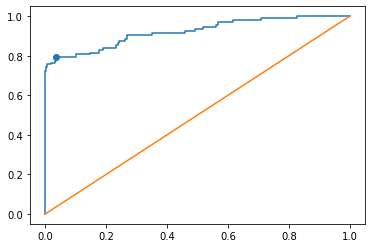

Best Threshold: 0.2901
Area Under the Curve: 0.9219


In [142]:
from sklearn.metrics import roc_curve

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,prob_val)
x = [0,1]

# Taxa de verdadeiros negativos = 1-fpr (1-(taxa de falsos positivos))
j_min = np.sqrt(tpr*(1-fpr)).argmax()


plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter((fpr[j_min]),tpr[j_min])
plt.show()
print('Best Threshold: %1.4f'%thresholds[j_min])
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())
threshold = thresholds[j_min]

In [143]:
val_prob = predict_prob(X_val_sc)
val_prob = val_prob[:,1]
y_val_pred_gmean = (val_prob>=threshold).astype(float)


test_prob = predict_prob(X_test_sc)
test_prob = test_prob[:,1]
y_test_pred_gmean = (test_prob>=threshold).astype(float)

**************Dados de Validação**************

F-beta score: 0.8235 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.825232,0.964089,0.889273,56863.000000
1.0,0.956824,0.795825,0.868930,56863.000000
accuracy,0.879957,0.879957,0.879957,0.879957
macro avg,0.891028,0.879957,0.879101,113726.000000
weighted avg,0.891028,0.879957,0.879101,113726.000000


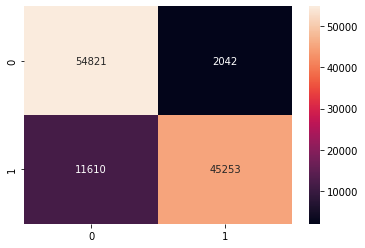

In [144]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score


print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

**************Dados de Teste**************

F-beta score: 0.1706 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999673,0.966639,0.982878,56863.000000
1.0,0.040950,0.818182,0.077997,99.000000
accuracy,0.966381,0.966381,0.966381,0.966381
macro avg,0.520312,0.892410,0.530438,56962.000000
weighted avg,0.998006,0.966381,0.981306,56962.000000


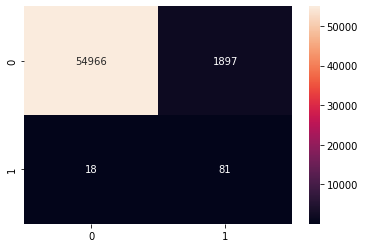

In [145]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

### F-Beta

O método F-Beta encontra a limiar maximizando a quantidade f-beta.

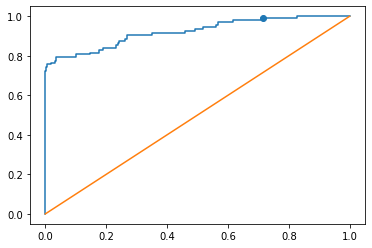

Best Threshold: 0.2180
Area Under the Curve: 0.9219


In [146]:
from sklearn.metrics import recall_score

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,prob_val)
x = [0,1]

n_thresholds = 50
np.random.seed(42)
random_thresholds = np.random.rand(n_thresholds)*(prob_val.max() - prob_val.min()) + prob_val.min()
np.random.seed(None)

# Neste caso vamos maximizar o f-beta com beta = 2
beta = 2
fbeta_scores = np.zeros((n_thresholds))
for j in range(n_thresholds):
  y_val_pred = (prob_val>=random_thresholds[j]).astype(float)
  fbeta_scores[j] = fbeta_score(y_val,y_val_pred,beta=beta)

j_max = fbeta_scores.argmax()


threshold = random_thresholds[j_max]


y_val_pred = (prob_val>=threshold).astype(float)
tpr_max = recall_score(y_val,y_val_pred)
fpr_max = 1 - recall_score(y_val,y_val_pred,pos_label=0)



plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter(fpr_max,tpr_max)
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [147]:
val_prob = predict_prob(X_val_sc)
val_prob = val_prob[:,1]
y_val_pred_fbeta = (val_prob>=threshold).astype(float)


test_prob = predict_prob(X_test_sc)
test_prob = test_prob[:,1]
y_test_pred_fbeta = (test_prob>=threshold).astype(float)

**************Dados de Validação**************

F-beta score: 0.8670 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.963956,0.283137,0.437708,56863.000000
1.0,0.579867,0.989413,0.731199,56863.000000
accuracy,0.636275,0.636275,0.636275,0.636275
macro avg,0.771912,0.636275,0.584454,113726.000000
weighted avg,0.771912,0.636275,0.584454,113726.000000


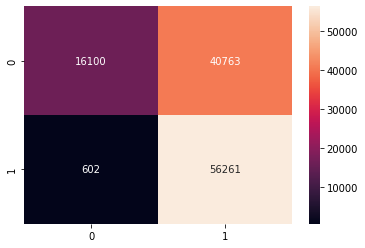

In [148]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

**************Dados de Teste**************

F-beta score: 0.0116 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999814,0.283084,0.441237,56863.000000
1.0,0.002349,0.969697,0.004687,99.000000
accuracy,0.284277,0.284277,0.284277,0.284277
macro avg,0.501082,0.626390,0.222962,56962.000000
weighted avg,0.998080,0.284277,0.440479,56962.000000


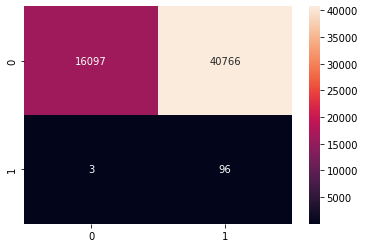

In [149]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

Aqui podemos notar que encontrar os parâmetros através do $F_{\beta}$ com $\beta = 2$ pode induzir um alto erro na previsão dos casos em que não-há fraude. Aparentemente G-Mean parece ser a métrica mais indicada para o nosso problema.

### Conclusões para K-Means

Vemos que em ambos os testes, apesar de um recall alto para a classe fraude, isto é, a maioria das fraudes são preditas realmente como fraude.

Porém a quantidade precision é muito baixa para a classe fraude. De forma simples, grande parte dos preditos como fraude não são fraudes. Isso é um problema incômodo, mas ainda assim pode valer a pena se pegar grande parte das fraudes.

Mas ainda devemos avaliar se esse comportamento é vantajoso. Por exemplo, no caso de escolha de limiar através do G-Mean obtemos as seguintes proporções:

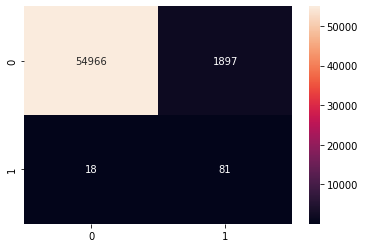

In [150]:
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

Vemos que a quantidade de falsos positivos é de 1897 que é pequeno comparado aos verdadeiros negativos, de 54966. Isso quer dizer que apesar de um número grande de transações preditas erroneamente como fraude, ainda assim é um percentual pequeno.

Por outro lado, 18 de um total de 99 fraudes do conjunto de teste escapam da classificação.

Esses resultados são relativamente bons, apesar de sempre podermos melhorar. Mas ainda há o dilema de reduzir o limiar e capturar mais fraudes e eventualmente bloquear mais clientes erroneamente, ou até aumentar o limiar e não capturar totalmente as fraudes.

Para isso deve-se ter uma base de cálculo e uma política clara no tratamento de fraudes podermos verificar o que é mais danoso à empresa e ao cliente.

# Testando IsolationForest

IsolationForest é um algoritmo que detecta outliers, que nesse caso iremos testar para verificar se esse algoritmo nos dá bons resultados na classificação de fraudes.

In [151]:
from sklearn.preprocessing import MinMaxScaler

# Mudança de escala para facilitar o treinamento e tornar os dados mais estáveis
# Iremos treinar somente utilizar os casos de não-fraude para prever outliers que serão preditos como fraude
X_nf_train_sc = sc_X.transform(X_nf_train)

Para ter um treino mais rápido, foi utilizado um truque de treinamento de florestas aleatórias com warm_start. 

Referências: 

[Documentação Oficial Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

[How to Fit Random Forests Faster](https://towardsdatascience.com/how-to-fit-random-forests-faster-a837de51d376)

In [152]:
from sklearn.ensemble import IsolationForest

n_splits = 5

np.random.seed(101)
idx = np.array(range(len(X_nf_train_sc)))
np.random.shuffle(idx)
splits = np.array_split(idx,n_splits)
np.random.seed(None)

max_features = range(3,9)

for n_features in max_features:
  clf = IsolationForest(n_estimators=0,max_features=n_features,warm_start=True)
  k = 1
  for idx in splits:
    clf.set_params(n_estimators=k*100)
    clf.fit(X_nf_train_sc[idx])
    k += 1

  prob_val = -clf.score_samples(X_val_sc)


  fpr, tpr, thresholds = roc_curve(y_val,prob_val)

  j_max = np.sqrt(tpr*(1-fpr)).argmax()
  Gmean = np.sqrt(tpr*(1-fpr)).max()
  threshold = thresholds[j_max]


  y_val_pred = (prob_val>=threshold).astype(float)
  beta = 2
  Fbeta_scores_ = fbeta_score(y_val.reshape(-1),y_val_pred,beta=beta)

  print('Max Features: %d,\t Threshold: %1.3f,\t G-Mean:%1.3f,\t fbeta: %1.3f,\t beta = %1.2f'%(n_features,threshold,Gmean,Fbeta_scores_,beta))


Max Features: 3,	 Threshold: 0.480,	 G-Mean:0.897,	 fbeta: 0.879,	 beta = 2.00
Max Features: 4,	 Threshold: 0.477,	 G-Mean:0.899,	 fbeta: 0.879,	 beta = 2.00
Max Features: 5,	 Threshold: 0.486,	 G-Mean:0.904,	 fbeta: 0.881,	 beta = 2.00
Max Features: 6,	 Threshold: 0.468,	 G-Mean:0.899,	 fbeta: 0.886,	 beta = 2.00
Max Features: 7,	 Threshold: 0.476,	 G-Mean:0.901,	 fbeta: 0.880,	 beta = 2.00
Max Features: 8,	 Threshold: 0.471,	 G-Mean:0.900,	 fbeta: 0.880,	 beta = 2.00


Utilizaremos max_features = 4, o maior valor obtido para fbeta.

In [153]:
clf = IsolationForest(n_estimators=0,max_features=4,warm_start=True)

n_splits = 5

np.random.seed(101)
idx = np.array(range(len(X_nf_train_sc)))
np.random.shuffle(idx)
splits = np.array_split(idx,n_splits)
np.random.seed(None)


k = 1
for idx in splits:
    clf.set_params(n_estimators=k*100)
    clf.fit(X_nf_train_sc[idx])
    k += 1
prob_val = -clf.score_samples(X_val_sc)
prob_test = -clf.score_samples(X_test_sc)

## Testando diferentes limiares (thresholds)

Definindo alguns testes e decidindo o melhor limiar (threshold) para prever as classes.

Referências: 

[A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

[Optimal Threshold for Imbalanced Classification](https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293)



### G-Mean

O método G-Mean encontra a limiar maximizando a média geométrica entre a taxa de verdadeiros positivos e a taxa de verdadeiros negativos.

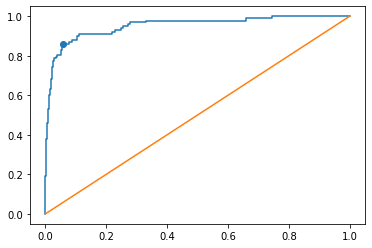

Best Threshold: 0.4825
Area Under the Curve: 0.9518


In [154]:
from sklearn.metrics import roc_curve

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,prob_val)
x = [0,1]

# Taxa de verdadeiros negativos = 1-fpr (1-(taxa de falsos positivos))
j_max = np.sqrt(tpr*(1-fpr)).argmax()


plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter((fpr[j_max]),tpr[j_max])
plt.show()
print('Best Threshold: %1.4f'%thresholds[j_max])
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())
threshold = thresholds[j_max]

In [155]:
y_val_pred_gmean = (prob_val>=threshold).astype(float)


y_test_pred_gmean = (prob_test>=threshold).astype(float)

**************Dados de Validação**************

F-beta score: 0.8726 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.868999,0.941315,0.903713,56863.000000
1.0,0.935988,0.858098,0.895352,56863.000000
accuracy,0.899706,0.899706,0.899706,0.899706
macro avg,0.902494,0.899706,0.899532,113726.000000
weighted avg,0.902494,0.899706,0.899532,113726.000000


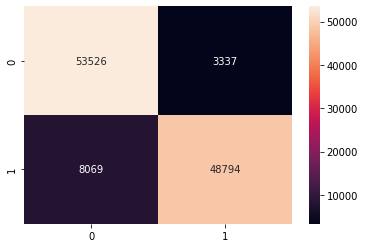

In [156]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score


print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

**************Dados de Teste**************

F-beta score: 0.1088 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999720,0.940541,0.969228,56863.000000
1.0,0.024242,0.848485,0.047138,99.000000
accuracy,0.940381,0.940381,0.940381,0.940381
macro avg,0.511981,0.894513,0.508183,56962.000000
weighted avg,0.998024,0.940381,0.967625,56962.000000


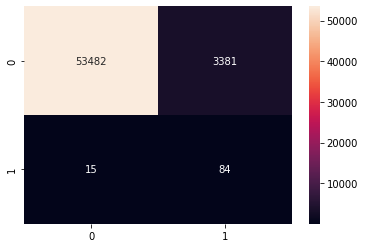

In [157]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

### F-Beta

O método F-Beta encontra a limiar maximizando a quantidade f-beta.

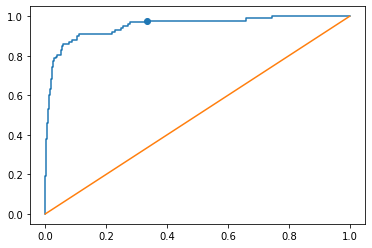

Best Threshold: 0.4216
Area Under the Curve: 0.9518


In [158]:
from sklearn.metrics import recall_score

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,prob_val)
x = [0,1]

n_thresholds = 50
np.random.seed(42)
random_thresholds = np.random.rand(n_thresholds)*(prob_val.max() - prob_val.min()) + prob_val.min()
np.random.seed(None)

# Neste caso vamos maximizar o f-beta com beta = 2
beta = 2
fbeta_scores = np.zeros((n_thresholds))
for j in range(n_thresholds):
  y_val_pred = (prob_val>=random_thresholds[j]).astype(float)
  fbeta_scores[j] = fbeta_score(y_val,y_val_pred,beta=beta)

j_max = fbeta_scores.argmax()


threshold = random_thresholds[j_max]


y_val_pred = (prob_val>=threshold).astype(float)
tpr_max = recall_score(y_val,y_val_pred)
fpr_max = 1 - recall_score(y_val,y_val_pred,pos_label=0)



plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter(fpr_max,tpr_max)
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [159]:
y_val_pred_fbeta = (prob_val>=threshold).astype(float)


y_test_pred_fbeta = (prob_test>=threshold).astype(float)

**************Dados de Validação**************

F-beta score: 0.9208 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.968596,0.665547,0.788972,56863.000000
1.0,0.745251,0.978422,0.846066,56863.000000
accuracy,0.821984,0.821984,0.821984,0.821984
macro avg,0.856924,0.821984,0.817519,113726.000000
weighted avg,0.856924,0.821984,0.817519,113726.000000


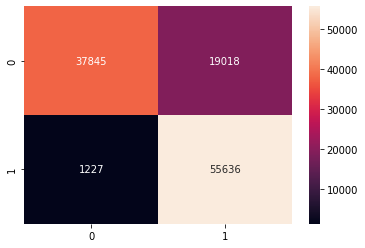

In [160]:
print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

**************Dados de Teste**************

F-beta score: 0.0233 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999814,0.661924,0.796517,56863.000000
1.0,0.004763,0.929293,0.009477,99.000000
accuracy,0.662389,0.662389,0.662389,0.662389
macro avg,0.502288,0.795609,0.402997,56962.000000
weighted avg,0.998085,0.662389,0.795149,56962.000000


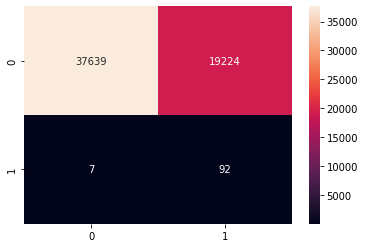

In [161]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

### Conclusões para IsolationForest

Vemos que em ambos os testes, apesar de um recall alto para a classe fraude, isto é, a maioria das fraudes são preditas realmente como fraude.

Porém a quantidade precision é muito baixa para a classe fraude. De forma simples, grande parte dos preditos como fraude não são fraudes. Isso é um problema incômodo, mas ainda assim pode valer a pena se pegar grande parte das fraudes.

Mas ainda devemos avaliar se esse comportamento é vantajoso. Por exemplo, no caso de escolha de limiar através do G-Mean obtemos as seguintes proporções:

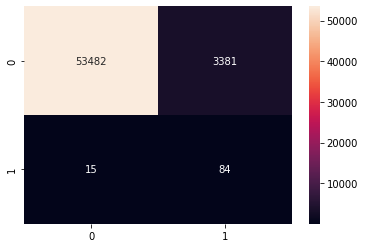

In [162]:
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
plt.show()

Em comparação com o caso método K-Means há um pequeno aumento do número de fraudes detectadas, mas por outro lado dobrou o número de falsos positivos. 

Neste caso pode não ser tão mais vantajoso quanto o resultado obtido por K-Means.

# Estudar Hyperopt

In [ ]:
# Hyperopt - hyperparameter optimization
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import space_eval



# Save model
from joblib import dump
from joblib import load
import json


# Models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#Time
from tqdm.notebook import tqdm


from sklearn.model_selection import cross_val_score

space = {}
penalties = ['l1','l2']
solver = 'liblinear'

lr = SGDClassifier

# Hyperparameters distributions
distributions = dict(alpha=hp.loguniform('alpha',np.log(1e-2),np.log(1e2)),penalty=hp.choice('penalty',('l1','l2')),model='LR')

space.update({'LR':distributions})



########################### CART ####################################


cart = DecisionTreeClassifier



# Hyperparameters distributions
distributions = dict(max_depth=hp.choice('max_depth',range(2,20)),model='CART')

space.update({'CART':distributions})







########################### Random Forest ####################################


rf = RandomForestClassifier



# Hyperparameters distributions
distributions = dict(max_depth=hp.choice('max_depth',[3, 4, 5, 6, 7, 8]),n_estimators=hp.choice('n_estimators',range(50,150)),model='RF')

space.update({'RF':distributions})





########################### SVR ####################################


SV_class = SVC

kernel = ['rbf']

# Hyperparameters distributions
distributions = dict(C=hp.loguniform('C',np.log(1e-2),np.log(1e5)),kernel=hp.choice('kernel',kernel),model='SVM')

space.update({'SVM':distributions})



########################### XGBoost ####################################
xgbc = XGBClassifier
# Hyperparameters distributions
param_dist = {'n_estimators': hp.choice('n_estimators',range(50, 150)),
              'learning_rate': hp.loguniform('learning_rate',np.log(5e-3), np.log(1e-1)),
              'subsample': hp.uniform('subsample',0.3, 0.6),
              'max_depth': hp.choice('max_depth',[3, 4, 5, 6, 7, 8]),
              'colsample_bytree': hp.uniform('colsample_bytree',0.4, 0.5),
              'min_child_weight': hp.choice('min_child_weight',[1, 2, 3, 4]),
              'eval_metric':'logloss',
              'use_label_encoder':False,
              'model':'XGBoost'
             }

space.update({'XGBoost':param_dist})



########################### XGBoost ####################################
knn = KNeighborsClassifier
# Hyperparameters distributions
distributions = dict(n_neighbors=hp.choice('n_neighbors',range(2,20)),model='KNN')

space.update({'KNN':distributions})

# get_space = 


model = {'LR':lr,
        'CART':cart,
        'RF':rf,
        'SVM':SV_class,
        'XGBoost':xgbc,
        'KNN':knn}



def get_acc_status(clf,X,y,X_val,y_val):
    # acc = cross_val_score(clf, X, y, cv=2).mean()
    clf.fit(X,y)
    y_pred = clf.predict(X_val)
    acc = sum(y_val==y_pred)/len(y_val)
    return {'loss': -acc, 'status': STATUS_OK}

def obj_fnc(params):
    get_params = params.copy()
    mdl = get_params.get('model')
    del get_params['model']
    clf = model[mdl](**get_params)
    return(get_acc_status(clf,X_train_sc,y_train.ravel(),X_val_sc,y_val.ravel()))

Best_model = {}
Results = {}
Best_params = {}
############ Model Loop ################
for s in tqdm(['LR', 'CART', 'RF', 'XGBoost', 'KNN']):
    # Random Grid Search CV
    print(s)
    hypopt_trials = Trials()
    clf = model[s]
    best_params = fmin(obj_fnc, space[s], algo=tpe.suggest,
                max_evals=15, trials= hypopt_trials)
    best_params = space_eval(space[s],best_params)
    del best_params['model']
    Best_params.update({s:best_params})
    # Choose the best estimator
    best_model_ = clf(**best_params)
    best_model_.fit(X_train_sc,y_train.ravel())
    y_pred = best_model_.predict(X_test_sc)
    filename = folder_name + 'model_' + s + '.skl'
    dump(clf,filename)
    Best_model.update({s:best_model_,s + ' filename':filename})
    Results.update({s:{'CV_score':hypopt_trials.best_trial['result']['loss'],
                      'Accuracy':accuracy_score(y_test.reshape(-1),y_pred.reshape(-1)),
                      'Classification Report':classification_report(y_test.reshape(-1),y_pred.reshape(-1),digits=4,output_dict=True)}})
    


with open(folder_name + 'Results.json','w') as f:
    json.dump(Results,f)

with open(folder_name + 'Best_params.json','w') as f:
    json.dump(Best_params,f)

  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:18<00:00,  1.21s/it, best loss: -0.9273429119110845]

100%|██████████| 15/15 [02:18<00:00,  9.22s/it, best loss: -0.6693016548546507]

100%|██████████| 15/15 [58:46<00:00, 235.08s/it, best loss: -0.9076200692893446]

100%|██████████| 15/15 [49:02<00:00, 196.14s/it, best loss: -0.8898317007544448]

100%|██████████| 15/15 [3:09:40<00:00, 758.73s/it, best loss: -0.807027416773649]


In [ ]:
for model in Results.keys():
    print(model)
    display(Results[model])

LR


{'Accuracy': 0.9989642217618764,
 'CV_score': -0.9273429119110845,
 'Classification Report': {'f1-score': {'0.0': 0.9994811590379457,
   '1.0': 0.7177033492822965,
   'accuracy': 0.9989642217618764,
   'macro avg': 0.8585922541601211,
   'weighted avg': 0.9989914289869326},
  'precision': {'0.0': 0.9995778512629283,
   '1.0': 0.6818181818181818,
   'accuracy': 0.9989642217618764,
   'macro avg': 0.8406980165405551,
   'weighted avg': 0.9990255847119816},
  'recall': {'0.0': 0.9993844855178236,
   '1.0': 0.7575757575757576,
   'accuracy': 0.9989642217618764,
   'macro avg': 0.8784801215467906,
   'weighted avg': 0.9989642217618764},
  'support': {'0.0': 56863.0,
   '1.0': 99.0,
   'accuracy': 0.9989642217618764,
   'macro avg': 56962.0,
   'weighted avg': 56962.0}}}

CART


{'Accuracy': 0.9980688880306169,
 'CV_score': -0.6693016548546507,
 'Classification Report': {'f1-score': {'0.0': 0.9990335108158926,
   '1.0': 0.0,
   'accuracy': 0.9980688880306169,
   'macro avg': 0.4995167554079463,
   'weighted avg': 0.9972971898023965},
  'precision': {'0.0': 0.9982616635353199,
   '1.0': 0.0,
   'accuracy': 0.9980688880306169,
   'macro avg': 0.49913083176765993,
   'weighted avg': 0.9965266839929935},
  'recall': {'0.0': 0.999806552591316,
   '1.0': 0.0,
   'accuracy': 0.9980688880306169,
   'macro avg': 0.499903276295658,
   'weighted avg': 0.9980688880306169},
  'support': {'0.0': 56863.0,
   '1.0': 99.0,
   'accuracy': 0.9980688880306169,
   'macro avg': 56962.0,
   'weighted avg': 56962.0}}}

RF


{'Accuracy': 0.9971735542993575,
 'CV_score': -0.9076200692893446,
 'Classification Report': {'f1-score': {'0.0': 0.9985830583058306,
   '1.0': 0.4615384615384615,
   'accuracy': 0.9971735542993575,
   'macro avg': 0.730060759922146,
   'weighted avg': 0.9976496743818116},
  'precision': {'0.0': 0.99947147739685,
   '1.0': 0.345,
   'accuracy': 0.9971735542993575,
   'macro avg': 0.672235738698425,
   'weighted avg': 0.9983340054635913},
  'recall': {'0.0': 0.9976962172238538,
   '1.0': 0.696969696969697,
   'accuracy': 0.9971735542993575,
   'macro avg': 0.8473329570967754,
   'weighted avg': 0.9971735542993575},
  'support': {'0.0': 56863.0,
   '1.0': 99.0,
   'accuracy': 0.9971735542993575,
   'macro avg': 56962.0,
   'weighted avg': 56962.0}}}

XGBoost


{'Accuracy': 0.9943295530353569,
 'CV_score': -0.8898317007544448,
 'Classification Report': {'f1-score': {'0.0': 0.9971533071872383,
   '1.0': 0.2962962962962963,
   'accuracy': 0.9943295530353569,
   'macro avg': 0.6467248017417673,
   'weighted avg': 0.9959352171609365},
  'precision': {'0.0': 0.9994523161725735,
   '1.0': 0.18888888888888888,
   'accuracy': 0.9943295530353569,
   'macro avg': 0.5941706025307312,
   'weighted avg': 0.9980435563098389},
  'recall': {'0.0': 0.9948648506058421,
   '1.0': 0.6868686868686869,
   'accuracy': 0.9943295530353569,
   'macro avg': 0.8408667687372644,
   'weighted avg': 0.9943295530353569},
  'support': {'0.0': 56863.0,
   '1.0': 99.0,
   'accuracy': 0.9943295530353569,
   'macro avg': 56962.0,
   'weighted avg': 56962.0}}}

KNN


{'Accuracy': 0.9988237772550121,
 'CV_score': -0.807027416773649,
 'Classification Report': {'f1-score': {'0.0': 0.999410983832825,
   '1.0': 0.6171428571428571,
   'accuracy': 0.9988237772550121,
   'macro avg': 0.808276920487841,
   'weighted avg': 0.9987466015333568},
  'precision': {'0.0': 0.9992089442041979,
   '1.0': 0.7105263157894737,
   'accuracy': 0.9988237772550121,
   'macro avg': 0.8548676299968359,
   'weighted avg': 0.9987072135730218},
  'recall': {'0.0': 0.9996131051826319,
   '1.0': 0.5454545454545454,
   'accuracy': 0.9988237772550121,
   'macro avg': 0.7725338253185887,
   'weighted avg': 0.9988237772550121},
  'support': {'0.0': 56863.0,
   '1.0': 99.0,
   'accuracy': 0.9988237772550121,
   'macro avg': 56962.0,
   'weighted avg': 56962.0}}}

# **Feature selection with the best model**

We can see that the Logistic Regression and XGBoost have similar performances, then by the simplicity of the Logistic Regression we will use this model

In [ ]:
import sys
import joblib

sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# Best model Feature Selector
xgb_class = Best_model['LR']

########################### Loop ####################################
# Forward Selection
sfs1 = sfs(xgb_class,k_features=7,forward=True,verbose=12,scoring='accuracy')
# Forward Feature Selection
X_train_sc_features = sfs1.fit_transform(X_train_sc,y_train.ravel())
X_test_sc_features = sfs1.transform(X_test_sc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  

In [ ]:
# Performance (cross-validation) for each number of features
feature_selection = pd.DataFrame(sfs1.subsets_).T
feature_selection

,feature_idx,cv_scores,avg_score,feature_names
1,"(13,)","[0.9154844949879829, 0.9139457178029193, 0.915...",0.915335,"(13,)"
2,"(11, 13)","[0.9254499091388709, 0.9241456122867695, 0.925...",0.925444,"(11, 13)"
3,"(11, 13, 15)","[0.9254205990972507, 0.9243361275573011, 0.925...",0.925555,"(11, 13, 15)"
4,"(11, 13, 15, 19)","[0.9255231842429216, 0.9244387127029721, 0.925...",0.925643,"(11, 13, 15, 19)"
5,"(11, 13, 15, 19, 23)","[0.9257136995134533, 0.9243800926197315, 0.925...",0.925666,"(11, 13, 15, 19, 23)"
6,"(7, 11, 13, 15, 19, 23)","[0.9256111143677824, 0.9244387127029721, 0.925...",0.925658,"(7, 11, 13, 15, 19, 23)"
7,"(7, 11, 13, 15, 16, 19, 23)","[0.9256843894718331, 0.9243800926197315, 0.925...",0.925652,"(7, 11, 13, 15, 16, 19, 23)"


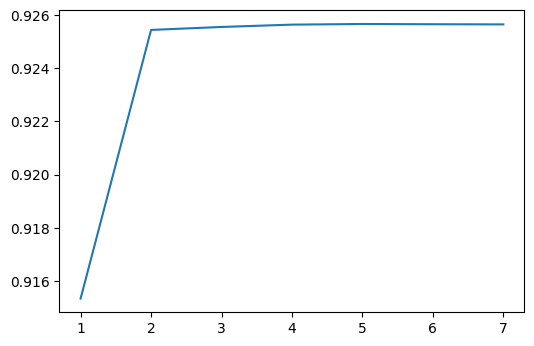

In [ ]:
# Features plot cross-validation average score
fig = plt.figure(dpi = 100)
plt.plot(feature_selection['avg_score'])
plt.show()

In [ ]:
feature_selection['avg_score'] = feature_selection['avg_score'].astype(float)
feature_selection['avg_score']

1    0.915335
2    0.925444
3    0.925555
4    0.925643
5    0.925666
6    0.925658
7    0.925652
Name: avg_score, dtype: float64

In [ ]:
features_selected = (10, 13)
feature_names = list(dataset.columns[list(features_selected)])


X_train_features = X_train[:,features_selected]
X_val_features = X_val[:,features_selected]
X_test_features = X_test[:,features_selected]


X_train_sc_features = X_train_sc[:,features_selected]
X_val_sc_features = X_val_sc[:,features_selected]
X_test_sc_features = X_test_sc[:,features_selected]

In [ ]:
# Hyperopt - hyperparameter optimization
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import space_eval



# Save model
from joblib import dump
from joblib import load
import json


# Models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#Time
from tqdm.notebook import tqdm


from sklearn.model_selection import cross_val_score

space = {}
penalties = ['l1','l2']
solver = 'liblinear'

lr = SGDClassifier

# Hyperparameters distributions
distributions = dict(alpha=hp.loguniform('alpha',np.log(1e-2),np.log(1e2)),penalty=hp.choice('penalty',('l1','l2')),model='LR')

space.update({'LR':distributions})



########################### CART ####################################


cart = DecisionTreeClassifier



# Hyperparameters distributions
distributions = dict(max_depth=hp.choice('max_depth',range(2,20)),model='CART')

space.update({'CART':distributions})







########################### Random Forest ####################################


rf = RandomForestClassifier



# Hyperparameters distributions
distributions = dict(max_depth=hp.choice('max_depth',range(2,10)),n_estimators=hp.choice('n_estimators',range(50,500)),model='RF')

space.update({'RF':distributions})





########################### SVR ####################################


SV_class = SVC

kernel = ['rbf']

# Hyperparameters distributions
distributions = dict(C=hp.loguniform('C',np.log(1e-2),np.log(1e5)),kernel=hp.choice('kernel',kernel),model='SVM')

space.update({'SVM':distributions})



########################### XGBoost ####################################
xgbc = XGBClassifier
# Hyperparameters distributions
param_dist = {'n_estimators': hp.choice('n_estimators',range(150, 500)),
              'learning_rate': hp.loguniform('learning_rate',np.log(5e-4), np.log(5e-2)),
              'subsample': hp.uniform('subsample',0.3, 0.6),
              'max_depth': hp.choice('max_depth',[3, 4, 5, 6, 7, 8, 9]),
              'colsample_bytree': hp.uniform('colsample_bytree',0.4, 0.5),
              'min_child_weight': hp.choice('min_child_weight',[1, 2, 3, 4]),
              'eval_metric':'logloss',
              'use_label_encoder':False,
              'model':'XGBoost'
             }

space.update({'XGBoost':param_dist})



########################### XGBoost ####################################
knn = KNeighborsClassifier
# Hyperparameters distributions
distributions = dict(n_neighbors=hp.choice('n_neighbors',range(2,20)),model='KNN')

space.update({'KNN':distributions})

# get_space = 


model = {'LR':lr,
        'CART':cart,
        'RF':rf,
        'SVM':SV_class,
        'XGBoost':xgbc,
        'KNN':knn}



def get_acc_status(clf,X,y,X_val,y_val):
    # acc = cross_val_score(clf, X, y, cv=2).mean()
    clf.fit(X,y)
    y_pred = clf.predict(X_val)
    acc = sum(y_val==y_pred)/len(y_val)
    return {'loss': -acc, 'status': STATUS_OK}

def obj_fnc(params):
    get_params = params.copy()
    mdl = get_params.get('model')
    del get_params['model']
    clf = model[mdl](**get_params)
    return(get_acc_status(clf,X_train_sc_features,y_train.ravel(),X_val_sc_features,y_val.ravel()))

Best_model = {}
Results = {}
Best_params = {}
############ Model Loop ################
for s in tqdm(['LR', 'CART', 'RF', 'XGBoost', 'KNN']):
    # Random Grid Search CV
    print(s)
    hypopt_trials = Trials()
    clf = model[s]
    best_params = fmin(obj_fnc, space[s], algo=tpe.suggest,
                max_evals=15, trials= hypopt_trials)
    best_params = space_eval(space[s],best_params)
    del best_params['model']
    Best_params.update({s:best_params})
    # Choose the best estimator
    best_model_ = clf(**best_params)
    best_model_.fit(X_train_sc_features,y_train.ravel())
    y_pred = best_model_.predict(X_test_sc_features)
    filename = folder_name + 'model_' + s + '_selected_features1.skl'
    dump(clf,filename)
    Best_model.update({s:{'model':best_model_,s + ' filename':filename}})
    Results.update({s:{'CV_score':hypopt_trials.best_trial['result']['loss'],
                      'Accuracy':accuracy_score(y_test.reshape(-1),y_pred.reshape(-1)),
                      'Classification Report':pd.DataFrame(classification_report(y_test.reshape(-1),y_pred.reshape(-1),digits=4,output_dict=True)).T.to_dict()}})



with open(folder_name + 'Results_selected_features1.json','w') as f:
    json.dump(Results,f)

with open(folder_name + 'Best_params_selected_features1.json','w') as f:
    json.dump(Best_params,f)

  0%|          | 0/5 [00:00<?, ?it/s]

LR

100%|██████████| 15/15 [00:11<00:00,  1.36it/s, best loss: -0.9065385224135202]
CART

100%|██████████| 15/15 [00:14<00:00,  1.04it/s, best loss: -0.9080069641067127]
RF

100%|██████████| 15/15 [15:17<00:00, 61.16s/it, best loss: -0.9082531698995832]
XGBoost

100%|██████████| 15/15 [13:07<00:00, 52.48s/it, best loss: -0.9295060056627332]
KNN

100%|██████████| 15/15 [01:11<00:00,  4.78s/it, best loss: -0.9058086980989396]


In [ ]:
for model in Results.keys():
    print(model)
    display(pd.DataFrame(Results[model]['Classification Report']))

LR


,precision,recall,f1-score,support
0.0,0.999542,0.998488,0.999015,56863.000000
1.0,0.459119,0.737374,0.565891,99.000000
accuracy,0.998034,0.998034,0.998034,0.998034
macro avg,0.729331,0.867931,0.782453,56962.000000
weighted avg,0.998603,0.998034,0.998262,56962.000000


CART


,precision,recall,f1-score,support
0.0,0.999678,0.982256,0.990890,56863.00000
1.0,0.074312,0.818182,0.136249,99.00000
accuracy,0.981970,0.981970,0.981970,0.98197
macro avg,0.536995,0.900219,0.563570,56962.00000
weighted avg,0.998070,0.981970,0.989405,56962.00000


RF


,precision,recall,f1-score,support
0.0,0.999693,0.972759,0.986042,56863.000000
1.0,0.050276,0.828283,0.094798,99.000000
accuracy,0.972508,0.972508,0.972508,0.972508
macro avg,0.524984,0.900521,0.540420,56962.000000
weighted avg,0.998043,0.972508,0.984493,56962.000000


XGBoost


,precision,recall,f1-score,support
0.0,0.999661,0.986177,0.992874,56863.000000
1.0,0.092379,0.808081,0.165803,99.000000
accuracy,0.985868,0.985868,0.985868,0.985868
macro avg,0.546020,0.897129,0.579338,56962.000000
weighted avg,0.998084,0.985868,0.991436,56962.000000


KNN


,precision,recall,f1-score,support
0.0,0.999524,0.996817,0.998169,56863.000000
1.0,0.284585,0.727273,0.409091,99.000000
accuracy,0.996348,0.996348,0.996348,0.996348
macro avg,0.642054,0.862045,0.703630,56962.000000
weighted avg,0.998281,0.996348,0.997145,56962.000000


# Autoencoder

In [ ]:
from sklearn.utils import resample

X = dataset.values[:,1:-1]
y = dataset.values[:,-1:]




n_examples = len(y)




X_nf = X[y.reshape(-1) == 0,:]
y_nf = y[y.ravel() == 0]
n_examples_nf = len(y_nf)

np.random.seed(101)
index_shuffling_nf = list(range(n_examples_nf))
np.random.shuffle(index_shuffling_nf)
np.random.seed(None)

X_nf,y_nf = X_nf[index_shuffling_nf,:],y_nf[index_shuffling_nf,:]

train_size_nf = int(n_examples_nf*0.6)
val_size_nf = int(n_examples_nf*0.2)
test_size_nf = n_examples_nf - train_size_nf - val_size_nf




X_nf_train,y_nf_train = X_nf[:train_size_nf],y_nf[:train_size_nf]
X_nf_val,y_nf_val = X_nf[train_size_nf:train_size_nf+val_size_nf],y_nf[train_size_nf:train_size_nf+val_size_nf]
X_nf_test,y_nf_test = X_nf[train_size_nf+val_size_nf:],y_nf[train_size_nf+val_size_nf:]




X_f = X[y.reshape(-1) == 1,:]
y_f = y[y.ravel() == 1]
n_examples_f = len(y_f)



np.random.seed(42)
index_shuffling_f = list(range(n_examples_f))
np.random.shuffle(index_shuffling_f)
np.random.seed(None)

X_f,y_f = X_f[index_shuffling_f,:],y_f[index_shuffling_f,:]



test_size_f = n_examples_f


X_f_test,y_f_test = X_f,y_f








X_train = X_nf_train
y_train = y_nf_train


X_val = X_nf_val
y_val = y_nf_val


X_test = np.concatenate((X_nf_test,X_f_test),axis=0)
y_test = np.concatenate((y_nf_test,y_f_test),axis=0)


train_size = len(y_train)
val_size = len(y_val)
test_size = len(y_test)
n_examples = train_size + val_size + test_size 


np.random.seed(101)
index_shuffling_train = list(range(train_size))
np.random.shuffle(index_shuffling_train)
np.random.seed(None)

X_train,y_train = X_train[index_shuffling_train],y_train[index_shuffling_train]


np.random.seed(101)
index_shuffling_val = list(range(val_size))
np.random.shuffle(index_shuffling_val)
np.random.seed(None)

X_val,y_val = X_val[index_shuffling_val],y_val[index_shuffling_val]


np.random.seed(101)
index_shuffling_test = list(range(test_size))
np.random.shuffle(index_shuffling_test)
np.random.seed(None)

X_test,y_test = X_test[index_shuffling_test],y_test[index_shuffling_test]


In [ ]:
from sklearn.preprocessing import MinMaxScaler


sc_X = MinMaxScaler()

X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.fit_transform(X_val)
X_test_sc = sc_X.transform(X_test)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms




device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

trainX,valX,testX = torch.tensor(X_train_sc),torch.tensor(X_val_sc),torch.tensor(X_test_sc)
trainX,valX,testX = trainX.unsqueeze(1),valX.unsqueeze(1),testX.unsqueeze(1)
trainX,valX,testX = trainX.type(torch.float),valX.type(torch.float),testX.type(torch.float)


trainY,valY,testY = torch.tensor(y_train).squeeze(1),torch.tensor(y_val).squeeze(1),torch.tensor(y_test).squeeze(1)
trainY,valY,testY = trainY.type(torch.LongTensor),valY.type(torch.LongTensor),testY.type(torch.LongTensor)


trainX,valX,testX = trainX.to(device),valX.to(device),testX.to(device)
trainY,valY,testY = trainY.to(device),valY.to(device),testY.to(device)

cuda:0


12
32


  0%|          | 0/51 [00:00<?, ?it/s]


Iteration: [0/4284], loss: 3.7304E-01

Iteration: [500/4284], loss: 2.1952E-03

Iteration: [1000/4284], loss: 2.1937E-03

Iteration: [1500/4284], loss: 2.1934E-03

Iteration: [2000/4284], loss: 2.1877E-03

Iteration: [2500/4284], loss: 2.1895E-03

Iteration: [3000/4284], loss: 2.1891E-03

Iteration: [3500/4284], loss: 2.1906E-03

Iteration: [4000/4284], loss: 2.1883E-03
Finished Training Trainset


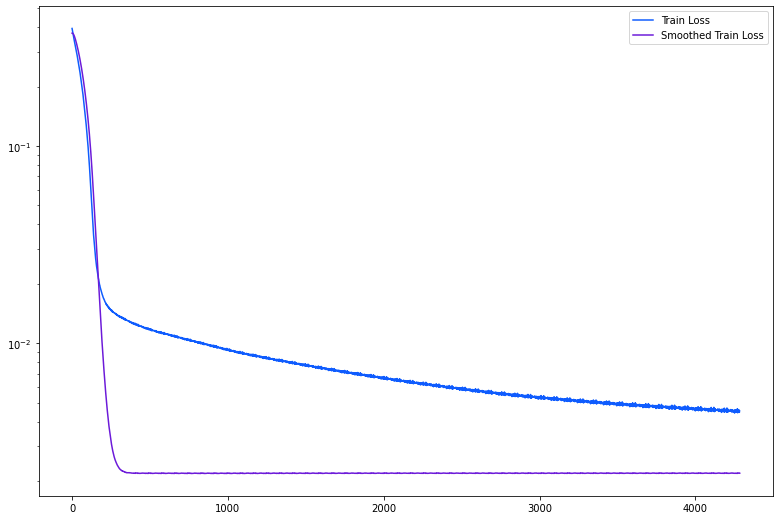

Train Loss: 4.5397E-03
Smoothed Loss: 2.1919E-03


In [ ]:
from tqdm.notebook import tqdm

conv_kernel_sz = [5,5,5,3]
num_channels_out = [2,4,8,16]
padding = [11,9,7,7]
stride = [1,1,1,1]


def encoding_size(square_image_length,kernel_size,stride,padding):
  conv_size = int((square_image_length-kernel_size+2*padding)/(stride)) + 1
  conv_size = int((conv_size-kernel_size+2*padding)/(stride)) + 1
  pooling_size = int((conv_size)/2)
  return pooling_size


def decode_size(square_image_length,kernel_size,stride,padding):
    upsampling = int((square_image_length)*2)
    conv_size = int((upsampling-kernel_size+2*padding)/(stride)) + 1
    conv_size = int((conv_size-kernel_size+2*padding)/(stride)) + 1
    return conv_size

n_features = X_train_sc.shape[1]

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv_kernel_sz_encode = [5,3]
        self.num_channels_encode = [4,8]
        self.padding_encode = [3,3]
        self.stride_encode = [1,1]

        n_layers = len(self.conv_kernel_sz_encode)
        output_size_ConvNet = n_features
        for i in range(n_layers):
            output_size_ConvNet=encoding_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz_encode[i],
                                          stride=self.stride_encode[i],
                                          padding=self.padding_encode[i])

        print(output_size_ConvNet)
        self.decode_size_ConvNet_encode = output_size_ConvNet
        
        
        self.conv_kernel_sz_decode = [5,5]
        self.num_channels_out_decode = [4,1]
        self.padding_decode = [1,0]
        self.stride_decode = [1,1]


        n_layers = len(self.conv_kernel_sz_decode)
        output_size_ConvNet = self.decode_size_ConvNet_encode
        for i in range(n_layers):
            output_size_ConvNet=decode_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz_decode[i],
                                          stride=self.stride_decode[i],
                                          padding=self.padding_decode[i])


        print(output_size_ConvNet)
        self.decode_size_ConvNet_decode = output_size_ConvNet
        

        
        
        self.layer1 =  nn.Sequential(nn.Conv1d(in_channels=1,out_channels=self.num_channels_encode[0],kernel_size=self.conv_kernel_sz_encode[0],padding=self.padding_encode[0],stride=self.stride_encode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_encode[0],out_channels=self.num_channels_encode[0],kernel_size=self.conv_kernel_sz_encode[0],padding=self.padding_encode[0],stride=self.stride_encode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.MaxPool1d(2))

        self.layer2 =  nn.Sequential(nn.Conv1d(in_channels=self.num_channels_encode[0],out_channels=self.num_channels_encode[1],kernel_size=self.conv_kernel_sz_encode[1],padding=self.padding_encode[1],stride=self.stride_encode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_encode[1],out_channels=self.num_channels_encode[1],kernel_size=self.conv_kernel_sz_encode[1],padding=self.padding_encode[1],stride=self.stride_encode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.AvgPool1d(2))

        self.layer3 =  nn.Sequential(nn.Upsample(scale_factor=(2), mode='linear',align_corners=True),
                        nn.Conv1d(in_channels=self.num_channels_encode[1],out_channels=self.num_channels_out_decode[0],kernel_size=self.conv_kernel_sz_decode[0],padding=self.padding_decode[0],stride=self.stride_decode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[0],out_channels=self.num_channels_out_decode[0],kernel_size=self.conv_kernel_sz_decode[0],padding=self.padding_decode[0],stride=self.stride_decode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU())

        self.layer4 =  nn.Sequential(nn.Upsample(scale_factor=(2), mode='linear',align_corners=True),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[0],out_channels=self.num_channels_out_decode[1],kernel_size=self.conv_kernel_sz_decode[1],padding=self.padding_decode[1],stride=self.stride_decode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[1],out_channels=self.num_channels_out_decode[1],kernel_size=self.conv_kernel_sz_decode[1],padding=self.padding_decode[1],stride=self.stride_decode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU())

        # self.layer5 =  nn.Sequential(nn.Linear())


        self.fc = nn.Linear(self.decode_size_ConvNet_decode*self.num_channels_out_decode[-1], n_features)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(-1,self.decode_size_ConvNet_decode*self.num_channels_out_decode[-1])
        out = self.fc(out)
        out = out.unsqueeze(1)
        return out

def train(model, optimizer, loss_f, num_epochs, batch_size, data_train_x, data_train_y, data_val_x, data_val_y):
    # data_train_y = data_train_y.clone()
    # data_train_x = data_train_x.clone()
    list_loss= []
    list_time = []
    valid_loss = []
    valid_losses = []
    avg_valid_losses = []

    val_size = len(data_val_y)


        
        
    j = 0
    m = len(data_train_y)
    num_batches = m//batch_size + 1 if m%batch_size>0 else m//batch_size

    alpha = .95
    exponential_decay_loss = []
    index = np.random.choice(range(val_size),size=2*batch_size)
    data = data_val_x[index] # Preditores
    target = data_val_y[index] # Labels
    # data = data.to(device)
    # target = target.to(device)
    loss = loss_f(model(data),target)
    exponential_decay_loss.append(loss.item())
    for epoch in tqdm(range(num_epochs)):
      for i in range(num_batches):
            X_batch = data_train_x[i*batch_size:(i+1)*batch_size]
            y_batch = data_train_y[i*batch_size:(i+1)*batch_size]
            outputs = model(X_batch)
            loss = loss_f(outputs, y_batch)

            #Replaces pow(2.0) with abs() for L1 regularization
     
            l1_lambda = 1e-4
            l1_norm = sum(p.abs().sum()
                          for p in model.parameters())

            loss = loss + l1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(i)


            model.eval() # prep model for evaluation
            # Utilizando o mesmo processo nos dados de validação
            index = np.random.choice(range(val_size),size=2*batch_size)
            data = data_val_x[index] # Preditores
            target = data_val_y[index] # Labels
            
            
            data = data.to(device)
            target = target.to(device)
            
            
            output = model(data)
            
            loss = loss_f(outputs, y_batch)
            valid_loss = loss.item()
            avg_valid_losses.append(valid_loss)
            
            exponential_decay_loss.append(alpha*exponential_decay_loss[-1] + (1-alpha)*valid_loss)


            if j % 500*num_batches == 0:
                print("\nIteration: [%d/%d], loss: %1.4E" % (j,num_batches*num_epochs, exponential_decay_loss[-1]))
            j += 1
      
    print('Finished Training Trainset')

    fig=plt.figure(figsize=(12,8))

    ax=fig.add_axes([.1,.1,.85,.85])

    ax.plot(list_loss,c='#0F5CFE',label='Train Loss')
    ax.plot(exponential_decay_loss,c='#6C1AD9',label='Smoothed Train Loss')
    ax.set_yscale('log')
    plt.legend()
    plt.show()
    print('Train Loss: %1.4E'% list_loss[-1])
    print('Smoothed Loss: %1.4E'% exponential_decay_loss[-1])
    return [exponential_decay_loss,list_loss]







batch_size = 2048


model = Autoencoder()

model = model.to(device)

loss_function = torch.nn.MSELoss()
# Hiperparametros
learning_rate = 5e-4
num_epochs = 51

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0e-5)

[exponential_decay_loss,list_loss] = train(model, optimizer, loss_function, num_epochs, batch_size, trainX, trainX, valX, valX)



In [ ]:
testX_autoencoder = model(testX)
testX_autoencoder = testX_autoencoder.squeeze(1)
X_test_sc_pred = testX_autoencoder.cpu().detach().numpy()

valX_autoencoder = model(valX)
valX_autoencoder = valX_autoencoder.squeeze(1)
X_val_sc_pred = valX_autoencoder.cpu().detach().numpy()

In [ ]:
mse_val = np.mean(np.power(X_val_sc_pred - X_val_sc, 2), axis=1)
rmse_val = np.sqrt(mse_val)
error_val = pd.DataFrame({'Mean RMSE': [rmse_val.mean()],
                        'Median RMSE': [np.median(rmse_val)],
                        'Std. RMSE': [rmse_val.std()],
                        'IQR RMSE': [np.quantile(rmse_val,0.75) - np.quantile(rmse_val,0.25)],
                        'Mean MSE': [mse_val.mean()],
                        'Median MSE': [np.median(mse_val)],
                        'Std. MSE': [mse_val.std()],
                        'IQR MSE': [np.quantile(mse_val,0.75) - np.quantile(mse_val,0.25)]})
error_val

,Mean RMSE,Median RMSE,Std. RMSE,IQR RMSE,Mean MSE,Median MSE,Std. MSE,IQR MSE
0,0.137475,0.136273,0.009389,0.0092,0.018987,0.01857,0.003199,0.002514


In [ ]:
mse_test = np.mean(np.power(X_test_sc_pred - X_test_sc, 2), axis=1)
rmse_test = np.sqrt(mse_test)
error_test = pd.DataFrame({'Mean RMSE': [rmse_test.mean()],
                        'Median RMSE': [np.median(rmse_test)],
                        'Std. RMSE': [rmse_test.std()],
                        'IQR RMSE': [np.quantile(rmse_test,0.75) - np.quantile(rmse_test,0.25)],
                        'Mean MSE': [mse_test.mean()],
                        'Median MSE': [np.median(mse_test)],
                        'Std. MSE': [mse_test.std()],
                        'IQR MSE': [np.quantile(mse_test,0.75) - np.quantile(mse_test,0.25)]})
error_test

,Mean RMSE,Median RMSE,Std. RMSE,IQR RMSE,Mean MSE,Median MSE,Std. MSE,IQR MSE
0,0.138222,0.136346,0.014554,0.009254,0.019317,0.01859,0.006378,0.002531


In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': mse_test,
                        'True_class': y_test.ravel()})

In [ ]:
from sklearn.metrics import fbeta_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report

thresholds = (0.04 - 0.001)*np.random.rand(100) + 0.001
threshold_list = []
for threshold in thresholds:
    y_test_pred = (mse_test>=threshold).astype(float)
    fbeta = fbeta_score(y_test.reshape(-1),y_test_pred,beta=2.0)
    threshold_list.append([threshold,fbeta])
threshold_list = np.array(threshold_list)
i_max = threshold_list[:,1].argmax()
threshold = threshold_list[i_max,0]
print('Best Threshold: %1.4f'%threshold)

Best Threshold: 0.0287


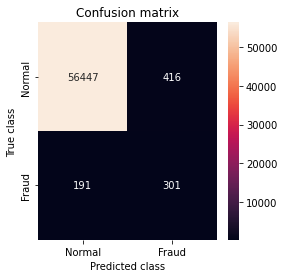

 Classification Report:
               precision    recall  f1-score   support

         0.0     0.9966    0.9927    0.9947     56863
         1.0     0.4198    0.6118    0.4979       492

    accuracy                         0.9894     57355
   macro avg     0.7082    0.8022    0.7463     57355
weighted avg     0.9917    0.9894    0.9904     57355

 Accuracy:  0.9894167901665069
 Recall:  0.6117886178861789
 Precision:  0.4198047419804742


In [ ]:
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y

LABELS = ["Normal","Fraud"]


conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()# print Accuracy, precision and recall
print(" Classification Report:\n",classification_report(error_df['True_class'], error_df['pred'],digits=4))
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

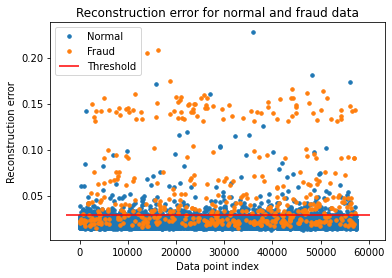

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
PATH = folder_name + 'autoencoder.ptc'
final_model = model.to('cpu')
torch.save(final_model.state_dict(), PATH)

In [ ]:
model = model.to(device)

# Variational Autoencoder

12
32


  0%|          | 0/51 [00:00<?, ?it/s]


Iteration: [0/4284], loss: 4.7049E-01

Iteration: [500/4284], loss: 5.2801E-03

Iteration: [1000/4284], loss: 2.6511E-03

Iteration: [1500/4284], loss: 2.5304E-03

Iteration: [2000/4284], loss: 2.4828E-03

Iteration: [2500/4284], loss: 2.4438E-03

Iteration: [3000/4284], loss: 2.4200E-03

Iteration: [3500/4284], loss: 2.3831E-03

Iteration: [4000/4284], loss: 2.3527E-03
Finished Training Trainset


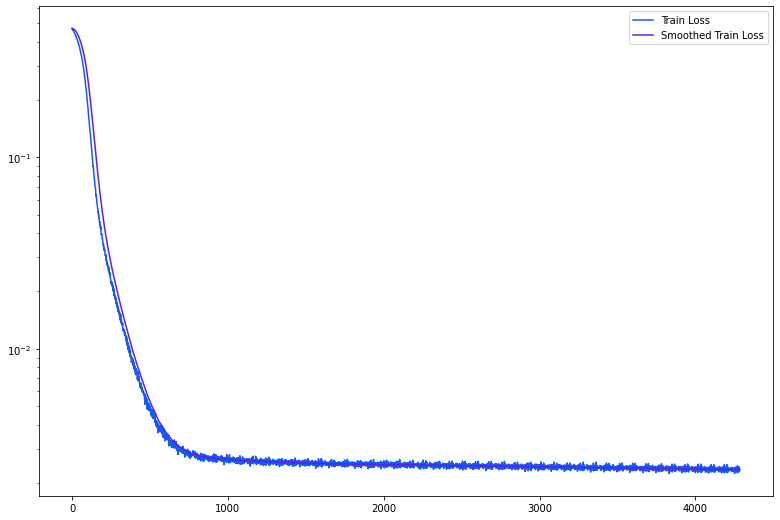

Train Loss: 2.3457E-03
Smoothed Loss: 2.3415E-03


In [ ]:
from tqdm.notebook import tqdm

conv_kernel_sz = [5,5,5,3]
num_channels_out = [2,4,8,16]
padding = [11,9,7,7]
stride = [1,1,1,1]


def encoding_size(square_image_length,kernel_size,stride,padding):
  conv_size = int((square_image_length-kernel_size+2*padding)/(stride)) + 1
  conv_size = int((conv_size-kernel_size+2*padding)/(stride)) + 1
  pooling_size = int((conv_size)/2)
  return pooling_size


def decode_size(square_image_length,kernel_size,stride,padding):
    upsampling = int((square_image_length)*2)
    conv_size = int((upsampling-kernel_size+2*padding)/(stride)) + 1
    conv_size = int((conv_size-kernel_size+2*padding)/(stride)) + 1
    return conv_size

n_features = X_train_sc.shape[1]

class Variational_Autoencoder(nn.Module):
    def __init__(self):
        super(Variational_Autoencoder, self).__init__()
        self.conv_kernel_sz_encode = [5,3]
        self.num_channels_encode = [4,8]
        self.padding_encode = [3,3]
        self.stride_encode = [1,1]

        n_layers = len(self.conv_kernel_sz_encode)
        output_size_ConvNet = n_features
        for i in range(n_layers):
            output_size_ConvNet=encoding_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz_encode[i],
                                          stride=self.stride_encode[i],
                                          padding=self.padding_encode[i])

        print(output_size_ConvNet)
        self.decode_size_ConvNet_encode = output_size_ConvNet
        
        
        self.conv_kernel_sz_decode = [5,5]
        self.num_channels_out_decode = [4,1]
        self.padding_decode = [1,0]
        self.stride_decode = [1,1]


        n_layers = len(self.conv_kernel_sz_decode)
        output_size_ConvNet = self.decode_size_ConvNet_encode
        for i in range(n_layers):
            output_size_ConvNet=decode_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz_decode[i],
                                          stride=self.stride_decode[i],
                                          padding=self.padding_decode[i])


        print(output_size_ConvNet)
        self.decode_size_ConvNet_decode = output_size_ConvNet
        

        self.fc_mu = nn.Linear(self.decode_size_ConvNet_encode, self.decode_size_ConvNet_encode)
        self.fc_std = nn.Sequential(nn.Linear(self.decode_size_ConvNet_encode, self.decode_size_ConvNet_encode),
                                    nn.Softplus())
        
        self.layer1 =  nn.Sequential(nn.Conv1d(in_channels=1,out_channels=self.num_channels_encode[0],kernel_size=self.conv_kernel_sz_encode[0],padding=self.padding_encode[0],stride=self.stride_encode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_encode[0],out_channels=self.num_channels_encode[0],kernel_size=self.conv_kernel_sz_encode[0],padding=self.padding_encode[0],stride=self.stride_encode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.MaxPool1d(2))

        self.layer2 =  nn.Sequential(nn.Conv1d(in_channels=self.num_channels_encode[0],out_channels=self.num_channels_encode[1],kernel_size=self.conv_kernel_sz_encode[1],padding=self.padding_encode[1],stride=self.stride_encode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_encode[1],out_channels=self.num_channels_encode[1],kernel_size=self.conv_kernel_sz_encode[1],padding=self.padding_encode[1],stride=self.stride_encode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.AvgPool1d(2))
        
        

        self.layer3 =  nn.Sequential(nn.Upsample(scale_factor=(2), mode='linear',align_corners=True),
                        nn.Conv1d(in_channels=self.num_channels_encode[1],out_channels=self.num_channels_out_decode[0],kernel_size=self.conv_kernel_sz_decode[0],padding=self.padding_decode[0],stride=self.stride_decode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[0],out_channels=self.num_channels_out_decode[0],kernel_size=self.conv_kernel_sz_decode[0],padding=self.padding_decode[0],stride=self.stride_decode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU())

        self.layer4 =  nn.Sequential(nn.Upsample(scale_factor=(2), mode='linear',align_corners=True),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[0],out_channels=self.num_channels_out_decode[1],kernel_size=self.conv_kernel_sz_decode[1],padding=self.padding_decode[1],stride=self.stride_decode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[1],out_channels=self.num_channels_out_decode[1],kernel_size=self.conv_kernel_sz_decode[1],padding=self.padding_decode[1],stride=self.stride_decode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU())

        # self.layer5 =  nn.Sequential(nn.Linear())


        self.fc = nn.Linear(self.decode_size_ConvNet_decode*self.num_channels_out_decode[-1], n_features)

    def forward(self, x):
        encode = self.layer1(x)
        encode = self.layer2(encode)

        mux = self.fc_mu(encode)
        stdx = self.fc_std(encode)


        p = torch.distributions.Normal(torch.zeros_like(mux),torch.ones_like(stdx))
        q = torch.distributions.Normal(mux,stdx)
        
        z = q.rsample()

        out = self.layer3(z)
        out = self.layer4(out)
        out = out.view(-1,self.decode_size_ConvNet_decode*self.num_channels_out_decode[-1])
        out = self.fc(out)
        out = out.unsqueeze(1)
        return out,z,p,q

def train(model, optimizer, loss_f, num_epochs, batch_size, data_train_x, data_train_y):
    # data_train_y = data_train_y.clone()
    # data_train_x = data_train_x.clone()
    list_loss= []
    list_time = []
    valid_loss = []
    valid_losses = []
    avg_valid_losses = []

    # val_size = len(data_val_y)


        
        
    j = 0
    m = len(data_train_y)
    num_batches = m//batch_size + 1 if m%batch_size>0 else m//batch_size

    alpha = .95
    exponential_decay_loss = []
    index = np.random.choice(range(val_size),size=2*batch_size)
    data = data_train_x[index] # Preditores
    target = data_train_y[index] # Labels
    # data = data.to(device)
    # target = target.to(device)

    outputs,z,p,q = model(data)
    loss1 = loss_f(outputs, target)

    
    
    
    # Kullback-Divergence
    loss_reg = (q.log_prob(z) - p.log_prob(z)).mean()
    loss = loss1 + loss_reg

    
    exponential_decay_loss.append(loss.item())
    for epoch in tqdm(range(num_epochs)):
      for i in range(num_batches):
            X_batch = data_train_x[i*batch_size:(i+1)*batch_size]
            y_batch = data_train_y[i*batch_size:(i+1)*batch_size]
            outputs,z,p,q = model(X_batch)
            loss1 = loss_f(outputs, y_batch)

            
            

            # Kullback-Divergence
            loss_reg = (q.log_prob(z) - p.log_prob(z)).mean()
            loss = loss1 + loss_reg


            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(i)


            # model.eval() # prep model for evaluation
            # Utilizando o mesmo processo nos dados de validação
            # index = np.random.choice(range(val_size),size=2*batch_size)
            # data = data_val_x[index] # Preditores
            # target = data_val_y[index] # Labels
            
            
            # data = data.to(device)
            # target = target.to(device)
            
            
            # outputs,z,p,q = model(data)
            
            
            # loss1 = loss_f(outputs, target)

            # # Kullback-Divergence
            # loss_reg = (q.log_prob(z) - p.log_prob(z)).mean()
            # loss = loss1 + loss_reg


            valid_loss = loss.item()
            avg_valid_losses.append(valid_loss)
            
            exponential_decay_loss.append(alpha*exponential_decay_loss[-1] + (1-alpha)*valid_loss)


            if j % 500*num_batches == 0:
                print("\nIteration: [%d/%d], loss: %1.4E" % (j,num_batches*num_epochs, exponential_decay_loss[-1]))
            j += 1
      
    print('Finished Training Trainset')

    fig=plt.figure(figsize=(12,8))

    ax=fig.add_axes([.1,.1,.85,.85])

    ax.plot(list_loss,c='#0F5CFE',label='Train Loss')
    ax.plot(exponential_decay_loss,c='#6C1AD9',label='Smoothed Train Loss')
    ax.set_yscale('log')
    plt.legend()
    plt.show()
    print('Train Loss: %1.4E'% list_loss[-1])
    print('Smoothed Loss: %1.4E'% exponential_decay_loss[-1])
    return [exponential_decay_loss,list_loss]







batch_size = 2048


model = Variational_Autoencoder()

model = model.to(device)

loss_function = torch.nn.MSELoss() 
regularization_function = torch.nn.KLDivLoss()
# Hiperparametros
learning_rate = 5e-4
num_epochs = 51

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

[exponential_decay_loss,list_loss] = train(model, optimizer, loss_function, num_epochs, batch_size, trainX, trainX)



In [ ]:
testX_autoencoder,_,_,_ = model(testX)
testX_autoencoder = testX_autoencoder.squeeze(1)
X_test_sc_pred = testX_autoencoder.cpu().detach().numpy()

valX_autoencoder,_,_,_ = model(valX)
valX_autoencoder = valX_autoencoder.squeeze(1)
X_val_sc_pred = valX_autoencoder.cpu().detach().numpy()

In [ ]:
mse_val = np.mean(np.power(X_val_sc_pred - X_val_sc, 2), axis=1)
rmse_val = np.sqrt(mse_val)
error_val = pd.DataFrame({'Mean RMSE': [rmse_val.mean()],
                        'Median RMSE': [np.median(rmse_val)],
                        'Std. RMSE': [rmse_val.std()],
                        'IQR RMSE': [np.quantile(rmse_val,0.75) - np.quantile(rmse_val,0.25)],
                        'Mean MSE': [mse_val.mean()],
                        'Median MSE': [np.median(mse_val)],
                        'Std. MSE': [mse_val.std()],
                        'IQR MSE': [np.quantile(mse_val,0.75) - np.quantile(mse_val,0.25)]})
error_val

,Mean RMSE,Median RMSE,Std. RMSE,IQR RMSE,Mean MSE,Median MSE,Std. MSE,IQR MSE
0,0.137532,0.136394,0.009521,0.009323,0.019006,0.018603,0.003227,0.00255


In [ ]:
mse_test = np.mean(np.power(X_test_sc_pred - X_test_sc, 2), axis=1)
rmse_test = np.sqrt(mse_test)
error_test = pd.DataFrame({'Mean RMSE': [rmse_test.mean()],
                        'Median RMSE': [np.median(rmse_test)],
                        'Std. RMSE': [rmse_test.std()],
                        'IQR RMSE': [np.quantile(rmse_test,0.75) - np.quantile(rmse_test,0.25)],
                        'Mean MSE': [mse_test.mean()],
                        'Median MSE': [np.median(mse_test)],
                        'Std. MSE': [mse_test.std()],
                        'IQR MSE': [np.quantile(mse_test,0.75) - np.quantile(mse_test,0.25)]})
error_test

,Mean RMSE,Median RMSE,Std. RMSE,IQR RMSE,Mean MSE,Median MSE,Std. MSE,IQR MSE
0,0.138278,0.136503,0.01467,0.009406,0.019336,0.018633,0.006413,0.002575


In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': mse_test,
                        'True_class': y_test.ravel()})

In [ ]:
from sklearn.metrics import fbeta_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report

thresholds = (0.04 - 0.001)*np.random.rand(100) + 0.001
threshold_list = []
for threshold in thresholds:
    y_test_pred = (mse_test>=threshold).astype(float)
    fbeta = fbeta_score(y_test.reshape(-1),y_test_pred,beta=3.0)
    threshold_list.append([threshold,fbeta])
threshold_list = np.array(threshold_list)
i_max = threshold_list[:,1].argmax()
threshold = threshold_list[i_max,0]
print('Best Threshold: %1.4f'%threshold)

Best Threshold: 0.0250


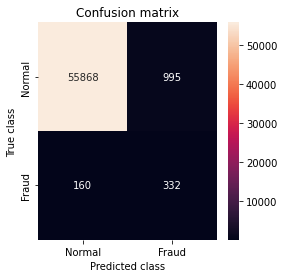

 Classification Report:
               precision    recall  f1-score   support

         0.0     0.9971    0.9825    0.9898     56863
         1.0     0.2502    0.6748    0.3650       492

    accuracy                         0.9799     57355
   macro avg     0.6237    0.8286    0.6774     57355
weighted avg     0.9907    0.9799    0.9844     57355

 Accuracy:  0.9798622613547207
 Recall:  0.6747967479674797
 Precision:  0.25018839487565936


In [ ]:
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y

LABELS = ["Normal","Fraud"]


conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()# print Accuracy, precision and recall
print(" Classification Report:\n",classification_report(error_df['True_class'], error_df['pred'],digits=4))
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

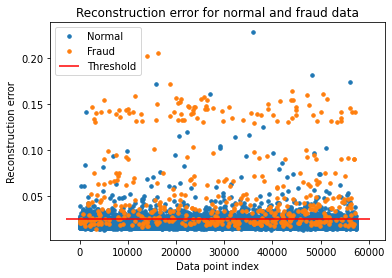

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

12
32


  0%|          | 0/11 [00:00<?, ?it/s]


Iteration: [0/924], loss: 3.4069E-01

Iteration: [500/924], loss: 1.8879E-02
Finished Training Trainset


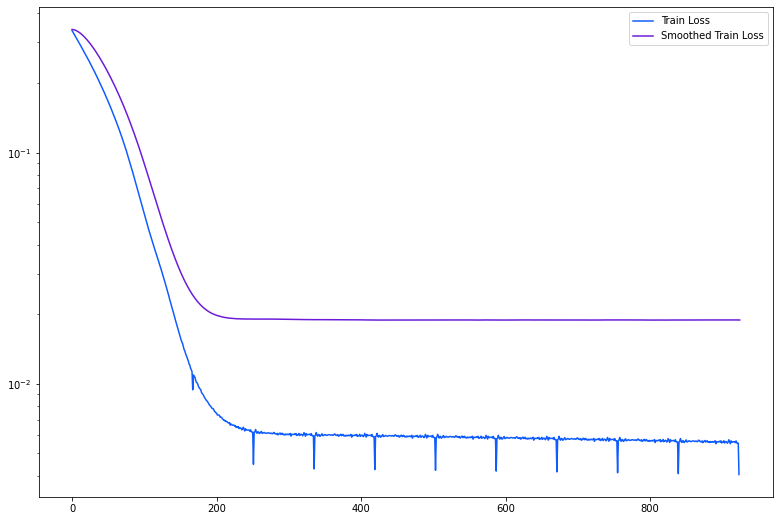

Train Loss: 4.0542E-03
Smoothed Loss: 1.8886E-02


In [ ]:
from tqdm.notebook import tqdm

conv_kernel_sz = [5,5,5,3]
num_channels_out = [2,4,8,16]
padding = [11,9,7,7]
stride = [1,1,1,1]


def encoding_size(square_image_length,kernel_size,stride,padding):
  conv_size = int((square_image_length-kernel_size+2*padding)/(stride)) + 1
  conv_size = int((conv_size-kernel_size+2*padding)/(stride)) + 1
  pooling_size = int((conv_size)/2)
  return pooling_size


def decode_size(square_image_length,kernel_size,stride,padding):
    upsampling = int((square_image_length)*2)
    conv_size = int((upsampling-kernel_size+2*padding)/(stride)) + 1
    conv_size = int((conv_size-kernel_size+2*padding)/(stride)) + 1
    return conv_size

n_features = X_train_sc.shape[1]

class Contractive_Autoencoder(nn.Module):
    def __init__(self):
        super(Contractive_Autoencoder, self).__init__()
        self.conv_kernel_sz_encode = [5,3]
        self.num_channels_encode = [4,8]
        self.padding_encode = [3,3]
        self.stride_encode = [1,1]

        n_layers = len(self.conv_kernel_sz_encode)
        output_size_ConvNet = n_features
        for i in range(n_layers):
            output_size_ConvNet=encoding_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz_encode[i],
                                          stride=self.stride_encode[i],
                                          padding=self.padding_encode[i])

        print(output_size_ConvNet)
        self.decode_size_ConvNet_encode = output_size_ConvNet
        
        
        self.conv_kernel_sz_decode = [5,5]
        self.num_channels_out_decode = [4,1]
        self.padding_decode = [1,0]
        self.stride_decode = [1,1]


        n_layers = len(self.conv_kernel_sz_decode)
        output_size_ConvNet = self.decode_size_ConvNet_encode
        for i in range(n_layers):
            output_size_ConvNet=decode_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz_decode[i],
                                          stride=self.stride_decode[i],
                                          padding=self.padding_decode[i])


        print(output_size_ConvNet)
        self.decode_size_ConvNet_decode = output_size_ConvNet
        

        
        
        self.layer1 =  nn.Sequential(nn.Conv1d(in_channels=1,out_channels=self.num_channels_encode[0],kernel_size=self.conv_kernel_sz_encode[0],padding=self.padding_encode[0],stride=self.stride_encode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_encode[0],out_channels=self.num_channels_encode[0],kernel_size=self.conv_kernel_sz_encode[0],padding=self.padding_encode[0],stride=self.stride_encode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.MaxPool1d(2))

        self.layer2 =  nn.Sequential(nn.Conv1d(in_channels=self.num_channels_encode[0],out_channels=self.num_channels_encode[1],kernel_size=self.conv_kernel_sz_encode[1],padding=self.padding_encode[1],stride=self.stride_encode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_encode[1],out_channels=self.num_channels_encode[1],kernel_size=self.conv_kernel_sz_encode[1],padding=self.padding_encode[1],stride=self.stride_encode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.AvgPool1d(2))

        self.layer3 =  nn.Sequential(nn.Upsample(scale_factor=(2), mode='linear',align_corners=True),
                        nn.Conv1d(in_channels=self.num_channels_encode[1],out_channels=self.num_channels_out_decode[0],kernel_size=self.conv_kernel_sz_decode[0],padding=self.padding_decode[0],stride=self.stride_decode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[0],out_channels=self.num_channels_out_decode[0],kernel_size=self.conv_kernel_sz_decode[0],padding=self.padding_decode[0],stride=self.stride_decode[0],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU())

        self.layer4 =  nn.Sequential(nn.Upsample(scale_factor=(2), mode='linear',align_corners=True),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[0],out_channels=self.num_channels_out_decode[1],kernel_size=self.conv_kernel_sz_decode[1],padding=self.padding_decode[1],stride=self.stride_decode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU(),
                        nn.Dropout(0.05),
                        nn.Conv1d(in_channels=self.num_channels_out_decode[1],out_channels=self.num_channels_out_decode[1],kernel_size=self.conv_kernel_sz_decode[1],padding=self.padding_decode[1],stride=self.stride_decode[1],groups=1),
                        # nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU())

        # self.layer5 =  nn.Sequential(nn.Linear())


        self.fc = nn.Linear(self.decode_size_ConvNet_decode*self.num_channels_out_decode[-1], n_features)

    def forward(self, x):
        out_e = self.layer1(x)
        out_e = self.layer2(out_e)
        out = self.layer3(out_e)
        out = self.layer4(out)
        out = out.view(-1,self.decode_size_ConvNet_decode*self.num_channels_out_decode[-1])
        out = self.fc(out)
        out = out.unsqueeze(1)
        return out_e,out

def train(model, optimizer, loss_f, num_epochs, batch_size, data_train_x, data_val_x):
    # data_train_y = data_train_y.clone()
    # data_train_x = data_train_x.clone()
    list_loss= []
    list_time = []
    valid_loss = []
    valid_losses = []
    avg_valid_losses = []

    val_size = len(data_val_x)


        
        
    j = 0
    m = len(data_train_x)
    num_batches = m//batch_size + 1 if m%batch_size>0 else m//batch_size

    alpha = .95
    exponential_decay_loss = []
    index = np.random.choice(range(val_size),size=2*batch_size)
    data = data_val_x[index] # Preditores
    
    data.requires_grad_(True)
    data.retain_grad()
    data.requires_grad_(True)
    
    # data = data.to(device)
    # target = target.to(device)
    outputs_e,outputs = model(data)
    
    

    l2_lambda = 1e-4


    loss1 = loss_f(outputs, data)

    outputs_e.backward(torch.ones(outputs_e.size()).to(device), retain_graph=True)    
    # Frobenious norm, the square root of sum of all elements (square value)
    # in a jacobian matrix 
    
    loss2 = torch.sqrt(torch.sum(torch.pow(data.grad,2)))
    data.grad.data.zero_()
    loss = loss1 + (l2_lambda*loss2) 





    data.requires_grad_(False)


    exponential_decay_loss.append(loss.item())
    for epoch in tqdm(range(num_epochs)):
      for i in range(num_batches):
            X_batch = data_train_x[i*batch_size:(i+1)*batch_size]



            
            X_batch.requires_grad_(True)
            X_batch.retain_grad()
            X_batch.requires_grad_(True)
            

            outputs_e,outputs = model(X_batch)




            loss1 = loss_f(outputs, X_batch)

            outputs_e.backward(torch.ones(outputs_e.size()).to(device), retain_graph=True)    
            # Frobenious norm, the square root of sum of all elements (square value)
            # in a jacobian matrix 
            loss2 = torch.sqrt(torch.sum(torch.pow(X_batch.grad,2)))
            X_batch.grad.data.zero_()
            loss = loss1 + (l2_lambda*loss2) 





            X_batch.requires_grad_(False)



            optimizer.zero_grad()


            loss.backward()

            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(i)


            model.eval() # prep model for evaluation
            # Utilizando o mesmo processo nos dados de validação
            index = np.random.choice(range(val_size),size=2*batch_size)
            data = data_val_x[index] # Preditores
            
            
            
            data = data.to(device)
            
            
            
            outputs_e, outputs = model(data)
            
            loss = loss_f(outputs, data)
            valid_loss = loss.item()
            avg_valid_losses.append(valid_loss)
            
            exponential_decay_loss.append(alpha*exponential_decay_loss[-1] + (1-alpha)*valid_loss)


            if j % 500*num_batches == 0:
                print("\nIteration: [%d/%d], loss: %1.4E" % (j,num_batches*num_epochs, exponential_decay_loss[-1]))
            j += 1
      
    print('Finished Training Trainset')

    fig=plt.figure(figsize=(12,8))

    ax=fig.add_axes([.1,.1,.85,.85])

    ax.plot(list_loss,c='#0F5CFE',label='Train Loss')
    ax.plot(exponential_decay_loss,c='#6C1AD9',label='Smoothed Train Loss')
    ax.set_yscale('log')
    plt.legend()
    plt.show()
    print('Train Loss: %1.4E'% list_loss[-1])
    print('Smoothed Loss: %1.4E'% exponential_decay_loss[-1])
    return [exponential_decay_loss,list_loss]







batch_size = 2048


model = Contractive_Autoencoder()

model = model.to(device)

loss_function = torch.nn.MSELoss()
# Hiperparametros
learning_rate = 5e-4
num_epochs = 11

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-6)

[exponential_decay_loss,list_loss] = train(model, optimizer, loss_function, num_epochs, batch_size, trainX, valX)



In [ ]:
_,testX_autoencoder = model(testX)
testX_autoencoder = testX_autoencoder.squeeze(1)
X_test_sc_pred = testX_autoencoder.cpu().detach().numpy()

_,valX_autoencoder = model(valX)
valX_autoencoder = valX_autoencoder.squeeze(1)
X_val_sc_pred = valX_autoencoder.cpu().detach().numpy()

In [ ]:
mse_val = np.mean(np.power(X_val_sc_pred - X_val_sc, 2), axis=1)
rmse_val = np.sqrt(mse_val)
error_val = pd.DataFrame({'Mean RMSE': [rmse_val.mean()],
                        'Median RMSE': [np.median(rmse_val)],
                        'Std. RMSE': [rmse_val.std()],
                        'IQR RMSE': [np.quantile(rmse_val,0.75) - np.quantile(rmse_val,0.25)],
                        'Mean MSE': [mse_val.mean()],
                        'Median MSE': [np.median(mse_val)],
                        'Std. MSE': [mse_val.std()],
                        'IQR MSE': [np.quantile(mse_val,0.75) - np.quantile(mse_val,0.25)]})
error_val

,Mean RMSE,Median RMSE,Std. RMSE,IQR RMSE,Mean MSE,Median MSE,Std. MSE,IQR MSE
0,0.137087,0.135875,0.009379,0.009199,0.018881,0.018462,0.003192,0.002506


In [ ]:
mse_test = np.mean(np.power(X_test_sc_pred - X_test_sc, 2), axis=1)
rmse_test = np.sqrt(mse_test)
error_test = pd.DataFrame({'Mean RMSE': [rmse_test.mean()],
                        'Median RMSE': [np.median(rmse_test)],
                        'Std. RMSE': [rmse_test.std()],
                        'IQR RMSE': [np.quantile(rmse_test,0.75) - np.quantile(rmse_test,0.25)],
                        'Mean MSE': [mse_test.mean()],
                        'Median MSE': [np.median(mse_test)],
                        'Std. MSE': [mse_test.std()],
                        'IQR MSE': [np.quantile(mse_test,0.75) - np.quantile(mse_test,0.25)]})
error_test

,Mean RMSE,Median RMSE,Std. RMSE,IQR RMSE,Mean MSE,Median MSE,Std. MSE,IQR MSE
0,0.137839,0.135937,0.014578,0.009228,0.019212,0.018479,0.006388,0.002517


In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': mse_test,
                        'True_class': y_test.ravel()})

In [ ]:
from sklearn.metrics import fbeta_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report

thresholds = (0.04 - 0.001)*np.random.rand(100) + 0.001
threshold_list = []
for threshold in thresholds:
    y_test_pred = (mse_test>=threshold).astype(float)
    fbeta = fbeta_score(y_test.reshape(-1),y_test_pred,beta=3.0)
    threshold_list.append([threshold,fbeta])
threshold_list = np.array(threshold_list)
i_max = threshold_list[:,1].argmax()
threshold = threshold_list[i_max,0]
print('Best Threshold: %1.4f'%threshold)

Best Threshold: 0.0286


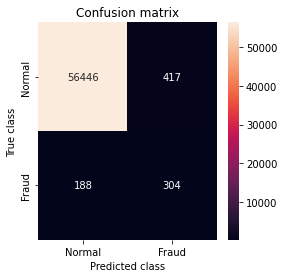

 Classification Report:
               precision    recall  f1-score   support

         0.0     0.9967    0.9927    0.9947     56863
         1.0     0.4216    0.6179    0.5012       492

    accuracy                         0.9895     57355
   macro avg     0.7092    0.8053    0.7480     57355
weighted avg     0.9917    0.9895    0.9904     57355

 Accuracy:  0.9894516607096155
 Recall:  0.6178861788617886
 Precision:  0.42163661581137307


In [ ]:
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y

LABELS = ["Normal","Fraud"]


conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()# print Accuracy, precision and recall
print(" Classification Report:\n",classification_report(error_df['True_class'], error_df['pred'],digits=4))
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

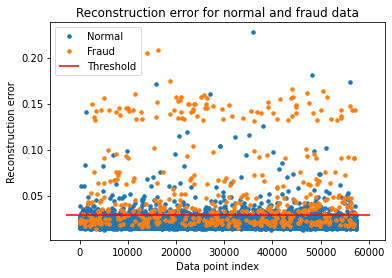

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
PATH = folder_name + 'autoencoder.ptc'
final_model = model.to('cpu')
torch.save(final_model.state_dict(), PATH)

In [ ]:
model = model.to(device)

In [ ]:
months = np.ones(12)
years = 30
percentual_year = 13
percentual_month = percentual_year**(1/12)


montante_inicial = montante = 10000
aportes = 750
for i in range(years):
  for j in range(12):
    montante = (1+(percentual_month/100))*montante + months[j]*aportes

montante_total = montante
rendimento_juros_total = montante - montante_inicial - years*np.sum(months)*aportes
total_aportado_total = montante_inicial + years*np.sum(months)*aportes



print('Montante final: %1.4f'%montante_total)
print('Rendimento Juros: %1.4f'%rendimento_juros_total)
print('Total Aportado: %1.4f'%total_aportado_total)

print('\n')
months[-1] = 0


montante_inicial = montante = 10000
for i in range(years):
  for j in range(12):
    montante = (1+(percentual_month/100))*montante + months[j]*aportes


montante_parcial = montante
rendimento_juros_parcial = montante - montante_inicial - years*np.sum(months)*aportes
total_aportado_parcial = montante_inicial + years*np.sum(months)*aportes



print('Montante final: %1.4f'%montante_parcial)
print('Rendimento Juros: %1.4f'%rendimento_juros_parcial)
print('Total Aportado: %1.4f'%total_aportado_parcial)

print('\n')

print('Razão Rendimentos: %1.4f'%(100*(1 - rendimento_juros_parcial/rendimento_juros_total)),'%')

Montante final: 5865336.9800
Rendimento Juros: 5585336.9800
Total Aportado: 280000.0000


Montante final: 5474301.7540
Rendimento Juros: 5216801.7540
Total Aportado: 257500.0000


Razão Rendimentos: 6.5983 %
